# Шаг 1
### Подключение необходимых библиотек

In [7]:
import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.special import comb, gamma
import scipy.stats as stats


# Шаг 2
### Функции для генерации случайных данных раличных распределений

In [8]:
def dataset_generator(name, seed, size):
    rnd_gen = np.random.default_rng(seed)
    # Геометническое распределение
    if (name == 'geometric'):
        p = rnd_gen.random()
        return name, rnd_gen.geometric(p, size=size)
    # Биномиальное распределение
    elif (name == 'binomial'):
        n = rnd_gen.integers(1, 1000)
        p = rnd_gen.random()
        return name, rnd_gen.binomial(n, p, size=size)
    # Распределение Пуассона
    elif (name == 'poisson'):
        expected_value = rnd_gen.integers(100)
        return name, rnd_gen.poisson(expected_value, size=size)
    # Равномерное распределение
    elif (name == 'uniform'):
        a = rnd_gen.integers(10)
        b = a + rnd_gen.integers(1, 10)
        return name, rnd_gen.uniform(a, b, size=size)
    # Нормальное распределение
    elif (name == 'normal'):
        expected_value = rnd_gen.integers(-10, 10)
        # Среднеквадратичное отклонение
        standart_deviation = rnd_gen.integers(1, 100)
        return name, rnd_gen.normal(expected_value, standart_deviation, size=size)
    # Экспоненциальное распределение
    elif (name == 'exponential'):
        expected_value = rnd_gen.integers(-10, 10)
        return name, rnd_gen.exponential(expected_value, size=size)

    
    
name, data = dataset_generator('uniform', seed=8, size=20)
print(name)
print(data)

uniform
[9.96183053 7.95613252 9.36564681 9.60968954 8.17325442 8.31364562
 8.11824671 7.32086079 8.43689636 7.72405644 7.77143575 7.55419467
 7.58159365 9.44148301 8.26895256 7.76776152 8.77270856 8.81281689
 8.94057408 9.73406914]


# Шаг 3
### Функции плотности распределения известных распределений

In [9]:
def normal_distribution(mean: float, variance: float, deviation: float):    
    return lambda x: 1 / (deviation * np.sqrt(2 * np.pi)) * np.exp(-(x - mean) ** 2 / (2 * variance)), 2

def exponential_distribution(mean: float):
    intensity = 1 / mean
    if intensity <= 0:
        return None
    else:
        return lambda x: intensity * math.exp(-intensity * x) if x >= 0 else 0, 1

def uniform_distribution(mean: float, variance: float):
    b = (3 * variance) ** 0.5 + mean
    a = 2 * mean - b   
    return lambda x: 1 / (b - a) if a <= x <= b else 0, 2 

def geometric_distribution(mean: float):
    p = 1 / mean
    if p > 1 or p <= 0:
        return None
    else:
        q = 1 - p
        return lambda x: q ** x * p if x >= 0 else 0, 3

def binomial_distribution(mean: float, n: int):
    p = mean / n
    if p > 1 or p < 0 or n < 0:
        return None
    else:
        return lambda x: comb(n, x) * (p ** x) * ((1 - p) ** (n - x)) if x >= 0 else 0, 2

def poisson_distribution(mean: float):
    return lambda x: math.exp(-mean) * (mean ** x) / gamma(x + 1) if x >= 0 else 0, 1

# Шаг 4
### Функция для разделения наблюдаемых значений на разряды
### Вовращает массив, в котором каждый элемент содержит данные разряда и среднеей

In [10]:
def split_into_intervals(lst, bins_count):
    if len(lst) == 0:
        return []

    sorted_lst = sorted(lst)
    
    res = []

    interval_len = (sorted_lst[-1]-sorted_lst[0]) / bins_count
    counter = sorted_lst[0]
    
    for i in sorted_lst: 
        if i >= counter:
            while counter <= i:      
                counter += interval_len

            res.append([[], 0, 0])
            
        res[-1][0].append(i)
        res[-1][1] += i
    
    for i in res:
        i[1] = ((i[0][0] + i[0][-1]) / 2) if len(i[0]) else 0
        i[2] = len(i[0]) / len(lst)
    
    return (res, interval_len)

print(split_into_intervals([0, 1, 1, 1, 7, 2, 8, 3, 3, 9, 4, 10, 5, 11, 6, 12], 6))

([[[0, 1, 1, 1], 0.5, 0.25], [[2, 3, 3], 2.5, 0.1875], [[4, 5], 4.5, 0.125], [[6, 7], 6.5, 0.125], [[8, 9], 8.5, 0.125], [[10, 11], 10.5, 0.125], [[12], 12.0, 0.0625]], 2.0)


# Шаг 5
### Функция для получения мат ожидания, дисперсии и среднего отклонения

In [11]:
def get_characteristics(intervals):
    expected_val = sum(x * p for _, x, p in intervals)
    variance = sum((x - expected_val)**2 * p for _, x, p in intervals)
    deviation = math.sqrt(variance)

    return expected_val, variance, deviation

# Шаг 6
### Проверка критерием Пирсона
### Если p весьма мало, то гипотеза отвергается

In [12]:
def pearson(intervals, density_func, k, l):
    r = len(intervals) - k - 1
    chi_2 = 0

    for interval in intervals:
        x = interval[1]
        m = len(interval[0])
        p = density_func(x) * l
        #print('p* =', interval[2])
        #print('p =', p)
        #print(m, n*p)
        if (p == 0):
            chi_2 += (interval[2] - p) ** 2 / 1e-10
        else:
            chi_2 += (interval[2] - p) ** 2 / p
        #chi_2 += (m - n * p)**2 / (n * p)
        #print((m - n * p)**2 / (n * p))
        #print('minus', (interval[2] - p) ** 2 / p)
        
    
    chi_2 = chi_2 * len(intervals)
    p_val = 1 - stats.chi2.cdf(chi_2, df=r)

    print('chi =', stats.chi2.cdf(chi_2, df=r))

    return chi_2, p_val

# Шаг 7
### Проверка критерием Колмогорова

In [13]:
def get_p(lmbda: float):
    P_TABLE = {0.0: 1.000, 0.1: 1.000, 0.2: 1.000, 0.3: 1.000, 0.4: 0.997,
            0.5: 0.964, 0.6: 0.864, 0.7: 0.711, 0.8: 0.544, 0.9: 0.393,
            1.0: 0.270, 1.1: 0.178, 1.2: 0.112, 1.3: 0.068, 1.4: 0.040,
            1.5: 0.022, 1.6: 0.012, 1.7: 0.006, 1.8: 0.003, 1.9: 0.002,
            2.0: 0.001, 3.0: 0.000}
    
    closest_key = min(P_TABLE.keys(), key=lambda x: abs(x - lmbda))
    return P_TABLE[closest_key]

def kolmogorov_criterion(intervals, density_func, lenght):
    x, y = [], [] 
    for interval in intervals:
        p = interval[2]
        if len(y) == 0:
            y.append(p)
        else:
            y.append(y[-1] + p)
        x.append(min(interval[0]))
    
    t_x, t_y = x.copy(), []
    for interval in t_x:
        p = density_func(interval + lenght / 2) * lenght
        if len(t_y) == 0:
            t_y.append(p)
        else:
            t_y.append(t_y[-1] + p)        
            
    t_y = [t_val / t_y[-1] for t_val in t_y]
    #print(x)
    #print(y)
    #print(t_x)
    #print(t_y)
    plt.plot(x, y, color='mediumblue')
    plt.plot(t_x, t_y, color='hotpink')
    plt.title('Kolmogorov')
    plt.show()    
    #print(y)
    #print(t_y)
    #print(max([abs(val - t_val) for val, t_val in zip(y, t_y)]))
    D = max([abs(val - t_val) for val, t_val in zip(y, t_y)])
    lmbda =  len(intervals) ** 0.5 * D
    p = get_p(lmbda)
    
    return lmbda, p

# Шаг 7
### Тесты

In [14]:
size = 1_000_000
bins = 15

name, data = dataset_generator('uniform', 3, size)

#data = ([-3.5] * 6)
#data.extend([-2.5] * 25)
#data.extend([-1.5] * 72)
#data.extend([-0.5] * 133)
#data.extend([0.5] * 120)
#data.extend([1.5] * 88)
#data.extend([2.5] * 46)
#data.extend([3.5] * 10)

#print(data)

intervals, lenght = split_into_intervals(data, bins)


expected_val, variance, deviation = get_characteristics(intervals)

#density_func, k = normal_distribution(expected_val, variance, deviation)
#density_func, k = poisson_distribution(expected_val)
#density_func, k = exponential_distribution(expected_val)
density_func, k = uniform_distribution(expected_val, variance)

print(expected_val, variance, deviation, lenght, k)

#for interval in intervals:
    #pprint(interval[0])
    #print(density_func(interval[1]))

8.500270476922282 0.08296079341772367 0.28802915376350996 0.06666655368469468 2


# Шаг 8

In [15]:
chi_2, p = pearson(intervals, density_func, k, lenght)

print(chi_2)
print(p)

chi = 3.7360608844512246e-11
0.16026110815927114
0.9999999999626394


# Шаг 9

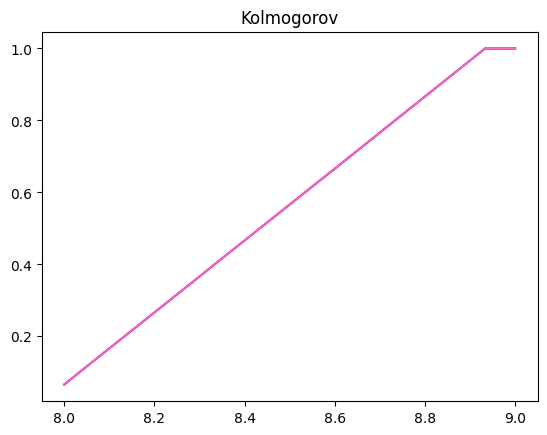

0.00255866666666682 1.0


In [16]:
lmbda, p = kolmogorov_criterion(intervals, density_func, lenght)

print(lmbda, p)

# Шаг 10

In [17]:
def circumcision(values, k):
    data = np.array(values)
    
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    
    return filtered_data

# Шаг 11

99010
chi = 0.00022926162785907604
Pirson
1.667064078480999
0.9997707383721409


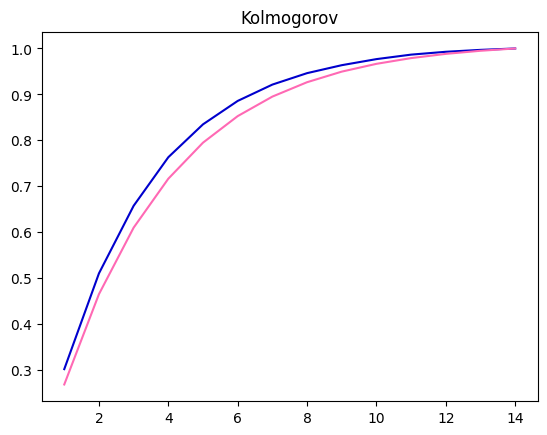

Kolmogorov
0.17828421600080646 1.0


In [18]:
values = pd.read_csv(r"set_1.csv", header=None, on_bad_lines='skip').values.tolist()[0]
data = circumcision(values, 3.5)
size = len(data)
print(size)

intervals, lenght = split_into_intervals(data, bins)


expected_val, variance, deviation = get_characteristics(intervals)

#density_func, k = normal_distribution(expected_val, variance, deviation)
#density_func, k = poisson_distribution(expected_val)
density_func, k = exponential_distribution(expected_val)
#density_func, k = uniform_distribution(expected_val, variance)


chi_2, p = pearson(intervals, density_func, k, lenght)

print('Pirson')
print(chi_2)
print(p)


lmbda, p = kolmogorov_criterion(intervals, density_func, lenght)

print('Kolmogorov')
print(lmbda, p)